# ENSO analysis of FOCI-OpenIFS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean 
from scipy.stats import linregress

In [2]:
from dask.distributed import Client, LocalCluster, wait

In [3]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36221 instead
  http_address["port"], self.http_server.port


In [4]:
client

Client Scheduler: tcp://127.0.0.1:37355 Dashboard: http://127.0.0.1:36221/status,Cluster Workers: 4 Cores: 8 Memory: 64.00 GB


In [5]:
exp_list = ['focioifs-merge14']

In [6]:
# OpenIFS surface
ds_sfc_all = []
for exp in exp_list:
    sfc = '/data/user/jkjellsson/esm-experiments/focioifs/%s/outdata/oifs/*1m*regular_sfc.nc' % (exp,)
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords').rename({'time_counter':'time'})
    ds_sfc_all.append(ds_sfc)

In [7]:
# OpenIFS plev
ds_pl_all = []
for exp in exp_list:
    pl = '/data/user/jkjellsson/esm-experiments/focioifs/%s/outdata/oifs/*1m*regular_pl.nc' % (exp,)
    ds_pl = xr.open_mfdataset(pl,combine='by_coords').rename({'time_counter':'time'})
    ds_pl_all.append(ds_pl)

In [34]:
# HadSST 
hadisst = '/data/user/swahl/reanalysis_obs/HADISST/HadISST_sst.nc'

ds_hadsst = xr.open_dataset(hadisst).rename({'longitude':'lon','latitude':'lat'})

sst_had = ds_hadsst['sst'].where(ds_hadsst['sst'] > -50)
sst_had = sst_had.sel(time=slice('1980-01-01','2010-01-01')).reindex(lat=sst_had.lat[::-1])

# Change lon to 0,360 to match OpenIFS
lon2 = np.where(sst_had['lon'] < 0, sst_had['lon'] + 360, sst_had['lon'])
sst_had = sst_had.assign_coords({"lon": lon2}).sortby('lon')

## ENSO functions

In [42]:
def enso(sst):
    """
    """
    sst_anom = sst.groupby('time.month') - sst.groupby('time.month').mean('time')
    sst_nino = sst_anom.sel(lon=slice(210,270),lat=slice(-5,5))
    nino = sst_nino.mean(('lon','lat'))
    nino_chnk = nino.chunk({'time':100})
    nino_run = nino_chnk.rolling(time=5,center=True).mean()
    
    # Find El Nino and La Nina events
    vals = nino_run.dropna('time').values
    el_nino_cut = vals.std()
    la_nina_cut = -vals.std()
    en = np.where(vals >= el_nino_cut)
    ln = np.where(vals <= la_nina_cut)
    
    return nino_run,en,ln

/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times mo

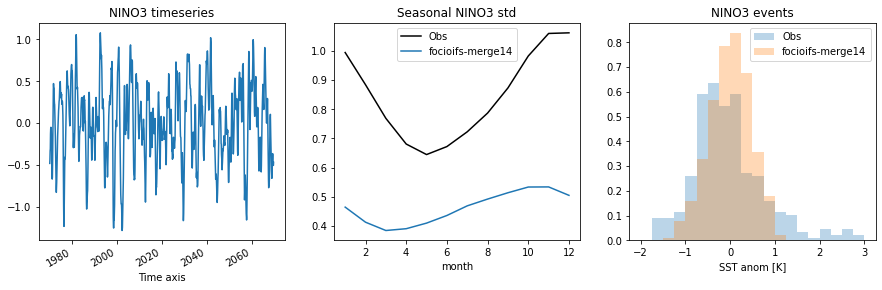

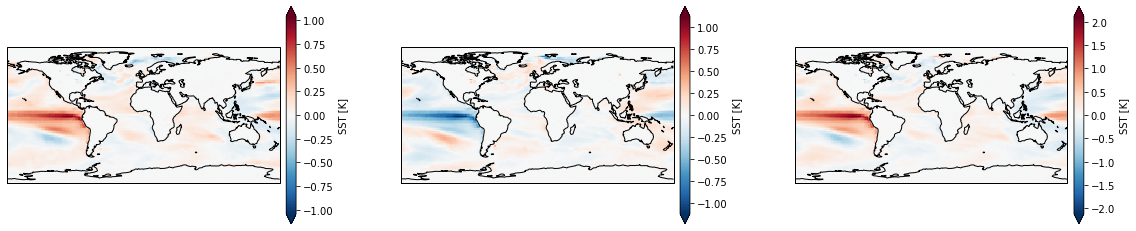

In [51]:
prj = ccrs.PlateCarree()

fig1, axs1 = plt.subplots(1,3,figsize=(15,4))
#fig2, axs2 = plt.subplots(len(exp_list),3,figsize=(20,5))
fig2  = plt.figure(figsize=(20,5))
axs2 = []
for i in range(0,len(exp_list)):
    for j in range(0,3):
        axs2.append( fig2.add_subplot(len(exp_list),3,j+i*3+1,projection=prj) )

# Obs ENSO
nino3_obs,elnino_obs,lanina_obs = enso(sst_had)
nino3_std = nino3_obs.groupby('time.month').std('time')
nino3_std.plot(ax=axs1[1],c='k',label='Obs')

sst_bins = np.arange(-2,3.25,0.25)
nino3_obs.plot.hist(ax=axs1[2],label='Obs',bins=sst_bins,alpha=0.3,density=True)

for i in range(0,len(exp_list)):
    exp = exp_list[i]
    ds_sfc = ds_sfc_all[i]
    sst = ds_sfc['sstk'][-1200:]
    
    # Compute NINO3 index and El Nino / La Nina events
    nino3,elnino,lanina = enso(sst)
    
    # Plot time series
    nino3.plot(ax=axs1[0])
    
    # Plot seasonal variance
    nino3_std = nino3.groupby('time.month').std('time')
    nino3_std.plot(ax=axs1[1],label=exp)
    
    # Histogram of events
    nino3.plot.hist(ax=axs1[2],label=exp,bins=sst_bins,alpha=0.3,density=True)
    
    # Composites of El Nino / La Nina events
    sst_anom = sst.groupby('time.month') - sst.groupby('time.month').mean('time')
    
    sst_en = sst_anom[elnino].mean('time') 
    sst_ln = sst_anom[lanina].mean('time') 
    
    ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'SST [K]'}
    sst_en.plot(ax=axs2[0],cbar_kwargs=ckw)
    sst_ln.plot(ax=axs2[1],cbar_kwargs=ckw)
    (sst_en - sst_ln).plot(ax=axs2[2],cbar_kwargs=ckw)
    
    for ax in axs2:
        ax.coastlines()

axs1[0].set_title('NINO3 timeseries')
axs1[1].set_title('Seasonal NINO3 std')
axs1[2].set_title('NINO3 events')
axs1[2].set_xlabel('SST anom [K]')
axs1[1].legend()
axs1[2].legend()

## Composites of fields

/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-or

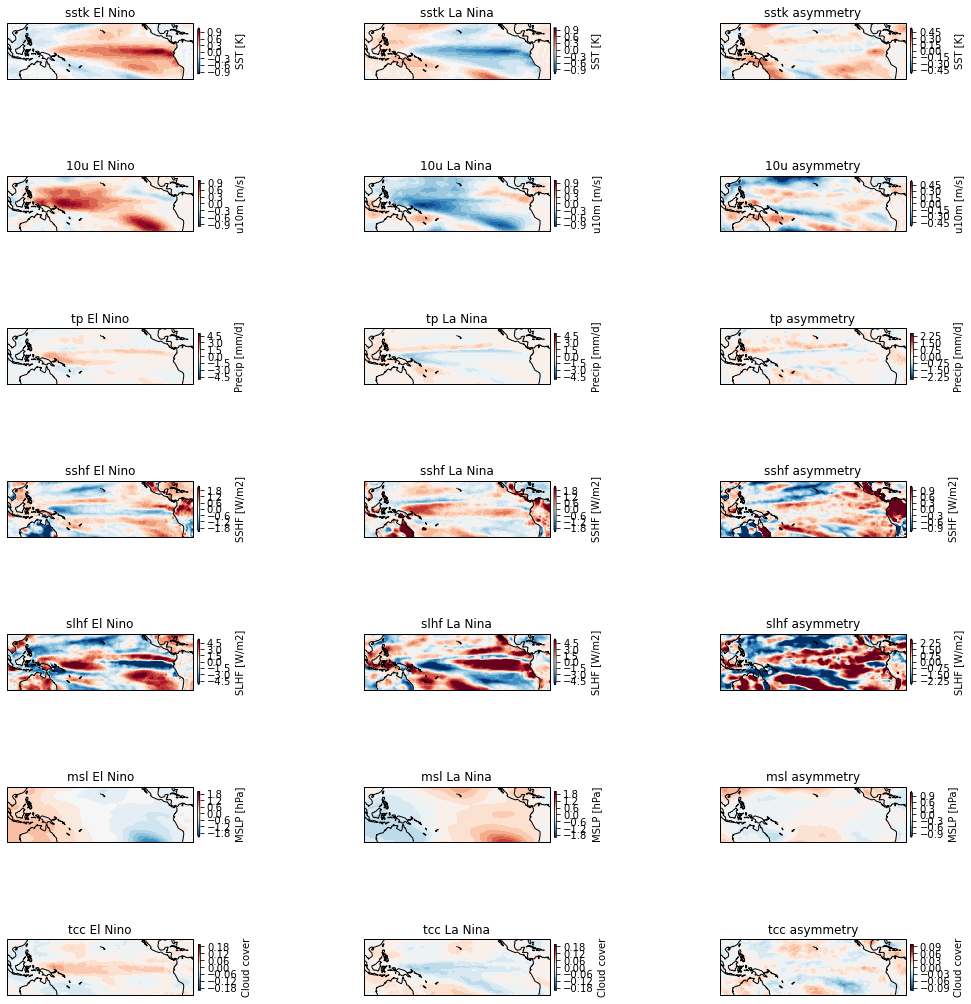

In [55]:
# Define the map projection we want for the plot
prj = ccrs.PlateCarree(central_longitude=180)
# Define the map projection for the data
prj0 = crs=ccrs.PlateCarree(central_longitude=0)

#
# Define the variables to plot
#
sstk = {'name':'sstk', 'label': 'SST [K]', 'vmin':-1, 'vmax': 1, 'scale': 1}
sshf = {'name':'sshf', 'label': 'SSHF [W/m2]', 'vmin':-2, 'vmax': 2, 'scale': 1/86400.}
slhf = {'name':'slhf', 'label': 'SLHF [W/m2]', 'vmin':-5, 'vmax': 5, 'scale': 1/86400.}
u10  = {'name':'10u', 'label': 'u10m [m/s]', 'vmin':-1, 'vmax': 1, 'scale': 1}
tp   = {'name':'tp', 'label': 'Precip [mm/d]', 'vmin':-5, 'vmax': 5, 'scale': 1000}
msl  = {'name':'msl', 'label': 'MSLP [hPa]', 'vmin':-2, 'vmax': 2, 'scale': 1e-2}
tcc  = {'name':'tcc', 'label': 'Cloud cover', 'vmin':-0.2, 'vmax': 0.2, 'scale': 1}

variables = [sstk, u10, tp, sshf, slhf, msl, tcc]
nvars = len(variables)

for i in range(0,len(exp_list)):
    
    fig1  = plt.figure(figsize=(15,15))
    axs1 = []
    for j in range(0,nvars):
        for k in range(0,3):
            # Use the projection we want to show
            axs1.append( fig1.add_subplot(nvars,3,k+j*3+1,projection=prj) )
    
    ds_sfc = ds_sfc_all[i]
    sst = ds_sfc['sstk'][-360:]
    
    # Compute NINO3 index and El Nino / La Nina events
    nino3,elnino,lanina = enso(sst)
    
    for j in range(0,nvars):
        
        var     = variables[j]
        name    = var['name']
        label   = var['label']
        scale   = var['scale']
        levels  = np.linspace(var['vmin'],var['vmax'],21)
        levels2 = np.linspace(var['vmin']/2,var['vmax']/2,21)
        
        # Composites of El Nino / La Nina events
        z = ds_sfc[name][-360:] * scale
        z_anom = z.groupby('time.month') - z.groupby('time.month').mean('time')
        
        z_en = z_anom[elnino].mean('time') 
        z_ln = z_anom[lanina].mean('time') 
    
        ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':label}
        
        # use transform so that cartopy knows the projection of the data
        z_en.plot.contourf(ax=axs1[0+j*3],levels=levels,cbar_kwargs=ckw,transform=prj0)
        z_ln.plot.contourf(ax=axs1[1+j*3],levels=levels,cbar_kwargs=ckw,transform=prj0)
        (z_en + z_ln).plot.contourf(ax=axs1[2+j*3],levels=levels2,cbar_kwargs=ckw,transform=prj0)
        
        axs1[0+j*3].set_title('%s El Nino' % (name,))
        axs1[1+j*3].set_title('%s La Nina' % (name,))
        axs1[2+j*3].set_title('%s asymmetry' % (name,))
        
    for ax in axs1:
        ax.coastlines()
        ax.set_extent([100,300,-30,30],crs=prj0)
    
    fig1.tight_layout()